# AdPMCMC on model $M_0$ and $M_2$

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import scipy
from scipy.stats import invgamma
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn
%pylab inline

#from numba import jit
from numpy import arange

from trajectorySimulation import trajectorySimulationM0, trajectorySimulationM0

Populating the interactive namespace from numpy and matplotlib


We begin by considering the model $M_0$ : 
\begin{equation}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_0 \sim \mathcal{N}(0, 1)$.
We use inverse Gamma priors for the variance noises :

$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$

$\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$

with hyperpameters $\alpha_\epsilon=\alpha_w=\frac{T}{2}$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

For synthetic data simulation, the authors set :

In [2]:
# General model parameters
b_0 = 0.15 
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 30 # time horizon

# model M2 additional parameters
b_2 = -0.125 
b_3 = 0.1 

# inverse gamma prior hyperparameters
alpha_eps = alpha_w =  T/2 
beta_eps = beta_w = 2*(alpha_eps - 1)/10

## MCMC kernel for $\theta$

In [3]:
from kernels import nonAdaptiveThetaProposal, adaptiveThetaProposal

## SMC sampler for $n_{1:T}$

In [4]:
def g(y, log_n, sigma_w):
    """
    Gaussian log-density for observation process
    """
    return -0.5*np.log(2*np.pi*sigma_w**2) - (y - np.exp(log_n))**2/(2*sigma_w**2)

#@jit
def stratifiedResampling(weights):
    """
    Stratified resampling
    Returns drawn indexes as a list
    weights needs to be a numpy array
    """
    n_samples = weights.shape[0]
        
    # Generate n_samples sorted uniforms with stratified sampling
    sorted_uniforms = np.zeros(n_samples)
    for n in range(n_samples):
        sorted_uniforms[n] = np.random.uniform(n/n_samples, (n+1)/n_samples)
        
    sampled_indexes = []
    j, partial_sum_weights = 0, weights[0]
    for n in range(n_samples):
        while sorted_uniforms[n] > partial_sum_weights:
            j += 1
            partial_sum_weights += weights[j]
        sampled_indexes += [j]
        
    return sampled_indexes

def q(theta_prev, theta):
    """
    Density of non-adaptive proposal kernel
    """
    d = theta.shape[0]
    return scipy.stats.multivariate_normal.pdf(theta, theta_prev, (0.1)**2/d * np.eye(d))

In the paper, there seems to be a simulation of $b_0$ per particles, see Algorithm 1, p.31, this seems odd.

See "Log-PF: Particle Filtering in Logarithm Domain" for log-normalization of weights

In [68]:
#@jit
def SMC_M0(y, T, L, n_0, b_0, sigma_eps, sigma_w):
    """
    Particle filter for M0 model
    y : observation trajectory
    T : time horizon
    L : number of particles
    n_0 : initial value of latent variable
    b_0, sigma_eps, sigma_w : M0 parameters
    """
    
    # Initialization of log particles and log-weights matrix
    log_particles = np.zeros((T, L))
    log_W = np.zeros((T, L))
    
    # Initialization of likelihood matrix 
    # Contains the obs likelihood for each particle
    w = np.zeros((T, L))
    
    # Initialization
    #log_particles[0, :] = np.log(n_0) + b_0 + np.random.normal(loc=0, scale=sigma_eps, size=L)
    log_particles[0, :] = np.log(n_0)
    
    # Log-weight computation
    for l in range(L):
        w[0, l] = g(y[0], log_particles[0, l], sigma_w)
        log_W[0, l] = w[0, l]
    
    # Log-weight normalization
    log_W[0, :] -= np.max(log_W[0, :]) # scaling   
    log_sum_of_weights = np.log(sum(np.exp(log_W[0, :]))) 
    log_W[0, :] -= log_sum_of_weights
        
    for t in range(1, T):
        for l in range(L):
            # Propagation
            log_particles[t, l] = log_particles[t-1, l] + b_0 + np.random.normal(0, sigma_eps)
                        
            # Log-weight computation
            w[t, l] = g(y[t], log_particles[t, l], sigma_w)
            log_W[t, l] = log_W[t-1, l] + w[t, l]
                
        # Weight normalization (log scale)
        log_W[t, :] -= np.max(log_W[t, :]) # scaling   
        log_sum_of_weights = np.log(sum(np.exp(log_W[t, :]))) 
        log_W[t, :] -= log_sum_of_weights
                            
        # Adaptive resampling : sample if ESS < 80% of number of particles
        ESS = 1/sum(np.exp(log_W[t, :])**2)
                        
        if ESS < 0.8*L:
            # resample indexes according to the normalized importance weights
            resampled_indexes = stratifiedResampling(np.exp(log_W[t, :]))
            log_particles[t, :] = log_particles[t, resampled_indexes]
            log_W[t, :] = np.log(np.ones(L)/L) # the new particles have equal weight
                
    # Evaluate marginal likelihood
            
    log_marginal_likelihood = np.sum(np.log(np.sum(np.exp(w), axis=1)/L))     
        
    return log_particles, log_W, log_marginal_likelihood

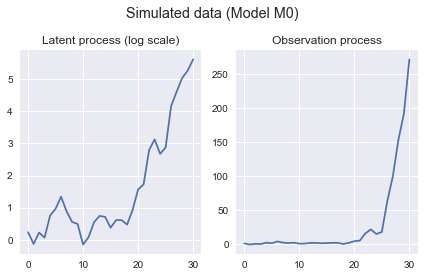

In [64]:
# General model parameters
b_0 = 0.12
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 30 # time horizon

# Simulate and plot a trajectory
log_N, Y = trajectorySimulationM0(T, n_0, b_0, sigma_eps, sigma_w)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data (Model M0)", fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

-115.64016373771005

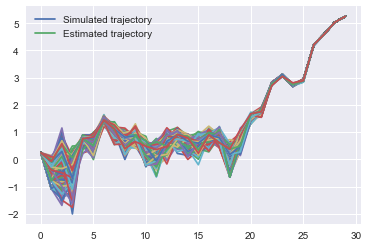

In [66]:
L = 200

log_particles, log_W, log_marginal_likelihood = SMC_M0(Y, T, L, n_0, b_0, sigma_eps, sigma_w)

log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
                          for t in range(T)]

plt.plot(log_N[:-1])
plt.plot(log_particles) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])
log_marginal_likelihood

## Stage 3 : Generic PMCMC

There seems to be a pb with marginal_eps_ratio and marginal_w_ratio

In [69]:
n_steps = 10000
L = 300

# draw uniforms for accept-reject procedure
uniforms = np.random.uniform(0, 1, n_steps)

# adaptive rate 
w = 0.5  # set to 0 -> non-adaptive proposal

# trajectory history
N_hist = []

# Theta initialization
b_0 = np.random.normal(0, 1)
#b_0 = 0.15
#sigma_eps = np.sqrt(invgamma.rvs(a=alpha_eps, scale=beta_eps))
sigma_eps = 0.47
#sigma_w = np.sqrt(invgamma.rvs(a=alpha_w, scale=beta_w))
sigma_w = 0.39

theta = np.array([b_0, sigma_eps, sigma_w])
theta_hist = [theta]

for j in range(n_steps):
    
    # draw candidate theta wrt non adaptive proposal
    if np.random.rand() < 1 - w or j < 100:
        theta_prop = nonAdaptiveThetaProposal(theta)
    else:
        theta_prop = adaptiveThetaProposal(theta_hist)
        
    # unpack theta
    b_0, sigma_eps, sigma_w = theta_prop
    #b_0 = 0.15
    sigma_eps = 0.47
    sigma_w = 0.39
    
    #what we really care about is sigma**2
    #sigma_eps, sigma_w = np.abs(sigma_eps), np.abs(sigma_w) 
    theta_prop = np.array([b_0, sigma_eps, sigma_w])
    
    # run SMC
    log_particles, log_W, log_marginal_likelihood = SMC_M0(
        Y, T, L, n_0, b_0, sigma_eps, sigma_w)

    # sample a candidate path
    idx = np.random.choice(a=L, size=1, p=np.exp(log_W[-1,:]))[0]
    candidate_path = log_particles[:, idx]

    # compute acceptance proba
    if j == 0:
        # always accept first draw (initialization)
        alpha = 1
        
    else:
        # last accepted theta
        b_0_prev, sigma_eps_prev, sigma_w_prev = theta
        
        # SMC marginal likelihood ratio
        marginal_likelihood_ratio = np.exp(log_marginal_likelihood - 
                                           prev_log_marginal_likelihood)
        
        # b_0 prior ratio
        marginal_b_ratio = np.exp(0.5*(b_0_prev**2 - b_0**2))
        
        #sigma_eps prior ratio
        #marginal_eps_ratio = np.exp(invgamma.logpdf(x=sigma_eps**2, a=alpha_eps, scale=beta_eps) -
        #                      invgamma.logpdf(x=sigma_eps_prev**2, a=alpha_eps, scale=beta_eps))
        
        # sigma_w prior ratio
        #marginal_w_ratio = (invgamma.pdf(x=sigma_w**2, a=alpha_w, scale=beta_w) / 
        #                    invgamma.pdf(x=sigma_w_prev**2, a=alpha_w, scale=beta_w))
        
        # theta proposal ratio (always equal to one because kernel is symmetric)
        theta_proposal_ratio = q(theta_prop, theta) / q(theta, theta_prop)
        
        alpha = (marginal_likelihood_ratio * marginal_b_ratio)
        
        #print('Alpha : {}'.format(alpha))
        #print(marginal_likelihood_ratio)
        #print(marginal_b_ratio)
        #print(marginal_eps_ratio)
        #print(marginal_w_ratio)
        #print(theta_proposal_ratio)
        
    if uniforms[j] < alpha:
        theta = theta_prop
        prev_log_marginal_likelihood = log_marginal_likelihood
        theta_hist.append(theta)
        N_hist.append(candidate_path)

In [70]:
len(theta_hist)

827

In [78]:
theta_history = theta_hist[100:]

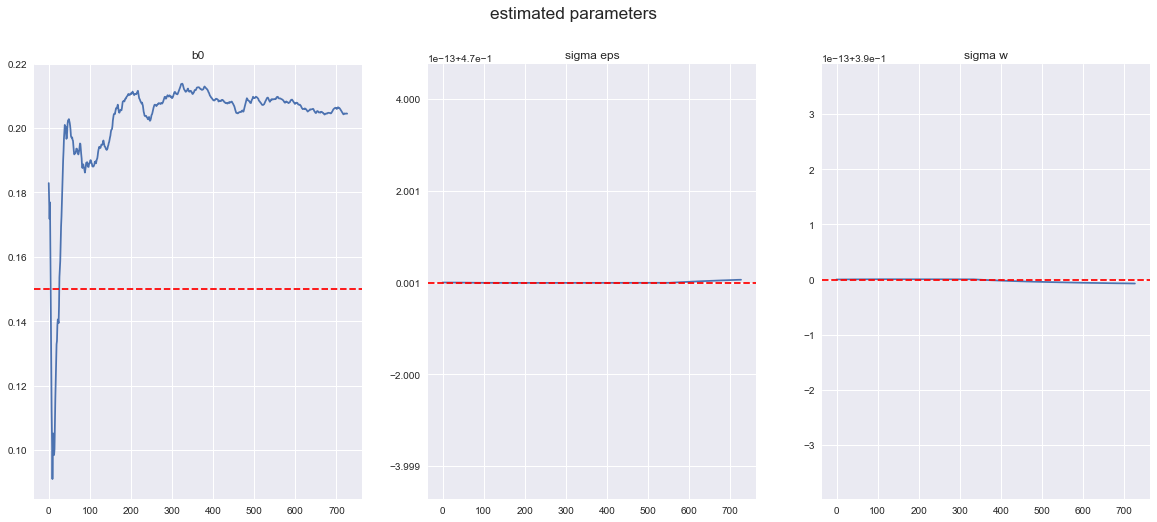

In [79]:
theta_history = np.array(theta_history)
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
st = f.suptitle("estimated parameters", fontsize="xx-large")

f.set_figwidth(20)
f.set_figheight(8)

ax1.plot(np.arange(len(theta_history)), np.cumsum(theta_history[:, 0]) / (np.arange(len(theta_history)) + 1))
ax1.axhline(y=0.15, color='r', linestyle='--')
ax1.set_title('b0')

ax2.plot(np.arange(len(theta_history)), np.cumsum(theta_history[:, 1]) / (np.arange(len(theta_history)) + 1))
ax2.axhline(y=0.47, color='r', linestyle='--')
ax2.set_title('sigma eps')

ax3.plot(np.arange(len(theta_history)),np.cumsum(theta_history[:, 2]) / (np.arange(len(theta_history)) + 1))
ax3.axhline(y=0.39, color='r', linestyle='--')
ax3.set_title('sigma w')

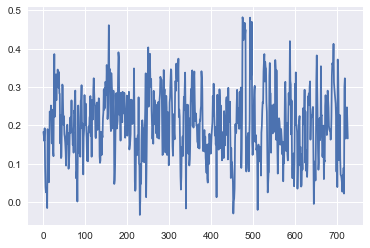

In [80]:
plt.plot(theta_history[:, 0])

In [81]:
np.sqrt(invgamma.mean(a=alpha_eps, scale=beta_eps))

0.44721359549995793

In [630]:
beta_eps

2.3